## Inferring a graph from binary signals

In [1]:
import networkx as nx
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import sys
sys.path.append('..')


In [2]:
from data import parliament_voting #load signals data

In [3]:
from statistical_learning import neighborhood_regression as nr #inferring graph via neighborhood regression

### Load tabular test data

* Test data is votes in german parliamentary (1 for "yes" and -1 for "no").
  * Each row stands for a member of parliament.
  * Columns contain votes of each member of parliament.
* Goal: We'd like to identify relationships in voting behaviour by learning a graph from voting signals, i.e. two nodes (=member of parliament) are connected if their voting behaviour is similar

In [4]:
df = parliament_voting.load()

In [5]:
df.head()

,Fraktion/Gruppe,Bezeichnung,vote_20200910_2,vote_20200916_1,vote_20200917_1,vote_20200918_1,vote_20200918_2,vote_20201008_1,vote_20201009_1,vote_20201009_2,...,vote_20201118_2,vote_20201118_3,vote_20201118_4,vote_20201119_1,vote_20201126_3,vote_20201208_1,vote_20201209_1,vote_20201211_1,vote_20201216_1,vote_20201217_1
0,CDU/CSU,Dr. Michael von Abercron,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,...,-1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0
1,CDU/CSU,Stephan Albani,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,...,-1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0
2,CDU/CSU,Norbert Maria Altenkamp,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,...,-1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0
3,CDU/CSU,Peter Altmaier,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,...,-1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0
4,CDU/CSU,Philipp Amthor,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,...,-1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0


In [6]:
signal_cols = [col for col in df.columns if 'vote' in col]

### Learn graph representation

In [7]:
neigh_reg = nr.NeighborhoodRegression()

In [8]:
neigh_reg.infer_graph(data=df[signal_cols],
                              signals='binary')

/home/morris/anaconda3/envs/graph_inference_learning/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [9]:
graph = neigh_reg.get_graph()

In [10]:
graph.number_of_nodes()

701

In [11]:
graph.number_of_edges()

1485

### Inspect result

In [12]:
party_dict = {i:party for i, party in enumerate(df['Fraktion/Gruppe'])}
politician_dict = {i:pol for i, pol in enumerate(df['Bezeichnung'])}
nx.set_node_attributes(graph, party_dict, 'party')
nx.set_node_attributes(graph, politician_dict, 'politician')

In [13]:
nx.number_connected_components(graph)

9

#### Visualize resulting graph

In [14]:
color_party_dict = {'CDU/CSU':'#000000',
                    'SPD':'#e3000f',
                    'DIE LINKE.':'#7a070f',
                    'AfD':'#009de0',
                    'FDP':'#ffef00',
                    'BÜ90/GR': '#64a12d',
                    'Fraktionslos':'#B7B7B7'}

In [15]:
nodes_list = list(graph.nodes)
node_colors = [color_party_dict.get(graph.nodes[n]['party']) for n in nodes_list]
pos = nx.drawing.layout.spring_layout(graph)

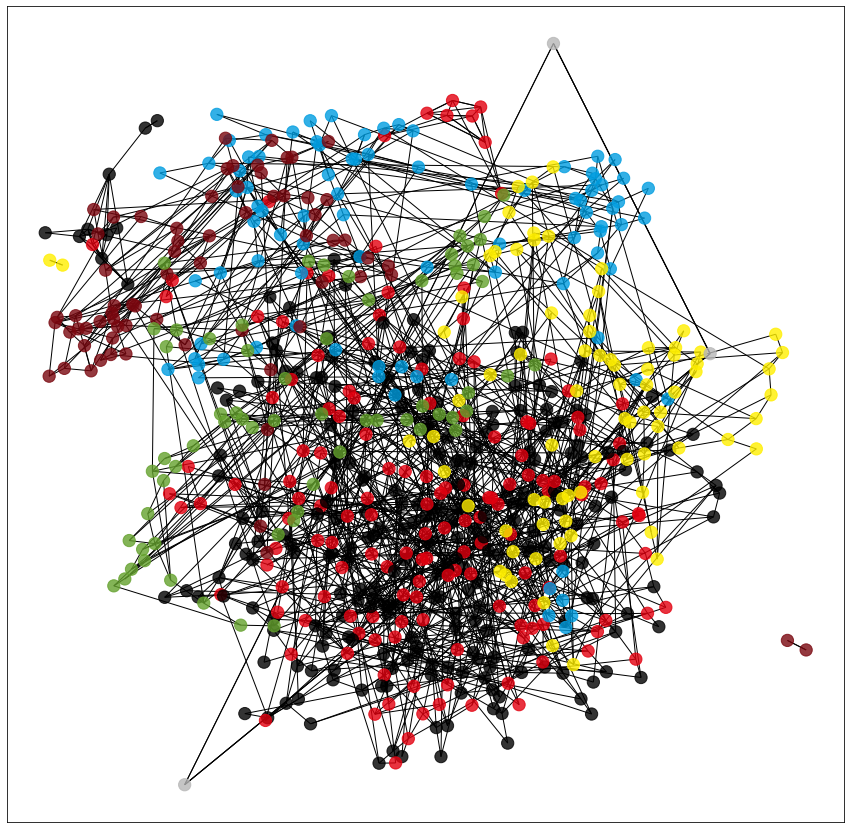

In [16]:
plt.figure(figsize=(15,15))
nodes_plot = nx.draw_networkx_nodes(G=graph,
                       pos=pos,
                       nodelist=nodes_list,
                       node_color=node_colors,
                       node_size=150,
                       linewidths=1,
                       alpha=0.8)

edges_plot = nx.draw_networkx_edges(G=graph,
                                   pos=pos)

#### Are there any interesting inter-party connections?

In [17]:
df.reset_index(inplace=True) #prepare merge with edges df

In [18]:
all_edges_df = pd.merge(left=neigh_reg.edges_df,
                         right=df[['index', 'Fraktion/Gruppe', 'Bezeichnung']],
                         left_on=['source'],
                         right_on=['index'],
                         how='left'
                        )
all_edges_df.drop(columns=['index'], inplace=True)
all_edges_df.rename({'Fraktion/Gruppe':'source_party',
                     'Bezeichnung':'source_politician'},
                    axis=1,
                    inplace=True)
all_edges_df = pd.merge(left=all_edges_df,
                         right=df[['index', 'Fraktion/Gruppe', 'Bezeichnung']],
                         left_on=['target'],
                         right_on=['index'],
                         how='left'
                        )

all_edges_df.drop(columns=['index'], inplace=True)
all_edges_df.rename({'Fraktion/Gruppe':'target_party',
                     'Bezeichnung':'target_politician'},
                    axis=1,
                    inplace=True)

In [19]:
all_edges_df.groupby(['source_party', 'target_party']).count()

source  target  weight  source_politician  \
source_party target_party                                              
AfD          AfD              176     176     176                176   
BÜ90/GR      BÜ90/GR          130     130     130                130   
             DIE LINKE.        13      13      13                 13   
CDU/CSU      CDU/CSU          334     334     334                334   
             SPD              193     193     193                193   
DIE LINKE.   DIE LINKE.       139     139     139                139   
FDP          FDP              160     160     160                160   
Fraktionslos Fraktionslos       8       8       8                  8   
SPD          CDU/CSU          182     182     182                182   
             SPD              150     150     150                150   

                           target_politician  
source_party target_party                     
AfD          AfD                         176  
BÜ90/GR      BÜ90/GR                     130  
             DIE LINKE.                   13  
CDU/CSU      CDU/CSU                     334  
             SPD                         193  
DIE LINKE.   DIE LINKE.                  139  
FDP          FDP                         160  
Fraktionslos Fraktionslos                  8  
SPD          CDU/CSU                     182  
             SPD                         150

Almost no inter-party connections except for SPD and CDU (they are in a coalition) and one connection between BÜ90/GR and DIE LINKE. This was pretty much expected.